In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

# Load the data and group it by unique keys for visualization

In [2]:
df_put = pd.read_table("loops_13.putative_cdr.txt", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt", sep="\t")

for key in set(df_put["pdb_id_kmer"]).intersection(df_cdr["pdb_id"]):
    df_put = df_put.loc[df_put["pdb_id_kmer"] != key,:]

In [3]:
df_put.head()

,pdb_id_kmer,chain_id_kmer,start_kmer,len_tcr,pos_tcr,aa_kmer,x_kmer,y_kmer,z_kmer,rmsd
0,12ca,A,72,13,0,A,0.000000,0.000000,0.000000,1.471901
1,12ca,A,72,13,1,V,2.435867,0.419666,2.914133,1.471901
2,12ca,A,72,13,2,L,3.901272,-1.472012,5.806936,1.471901
3,12ca,A,72,13,3,K,5.112862,0.373801,8.957265,1.471901
4,12ca,A,72,13,4,G,5.346375,-0.093429,12.738140,1.471901


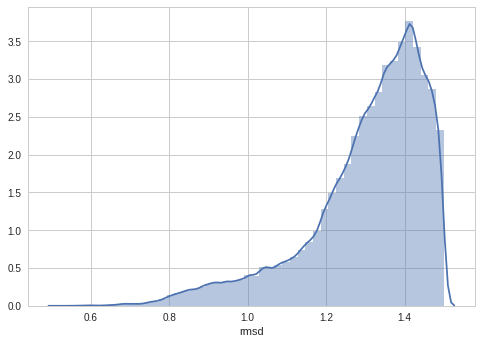

In [4]:
sns.distplot(df_put["rmsd"])

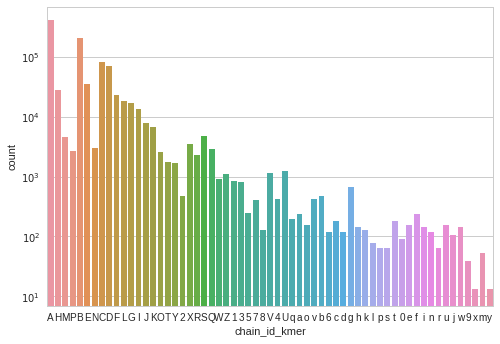

In [5]:
sns.countplot(df_put["chain_id_kmer"], log="y")

In [6]:
df_cdr.head()

,pdb_id,tcr_chain,len_tcr,pos_tcr,aa_tcr,x,y,z
0,2iam,TRA,13,0,C,0.000000,0.000000,0.000000
1,2iam,TRA,13,1,A,2.509573,1.112225,2.513987
2,2iam,TRA,13,2,A,3.364967,-0.345859,5.977036
3,2iam,TRA,13,3,L,5.778524,0.067249,8.943966
4,2iam,TRA,13,4,I,8.380416,-2.555646,9.870885


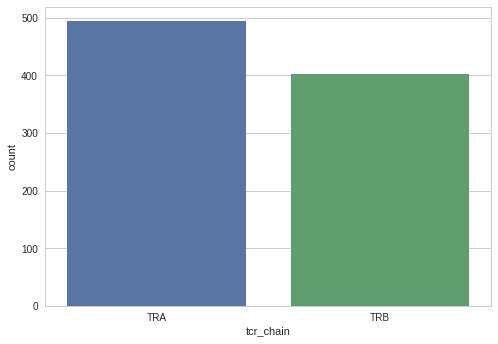

In [7]:
sns.countplot(df_cdr["tcr_chain"])

In [29]:
df = df_put.pivot_table("x_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], columns="pos_tcr")
df = df.reset_index()

df2 = df_put.pivot_table("aa_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], aggfunc=sum)
df2 = df2.reset_index()

df["sequence"] = df2["aa_kmer"]
df["key"] = df["pdb_id_kmer"] + "_" + df["chain_id_kmer"] + "_" + pd.Series(list(map(str, df["start_kmer"])))
df.drop(["pdb_id_kmer", "chain_id_kmer", "start_kmer"], axis=1, inplace=True)
df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
df_put_coord = df
df_put_coord.to_csv("put_coord_x.csv.gz", compression="gzip")
df_put_coord.head()

pos_tcr,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12ca_A_72,AVLKGGPLDGTYR,0.0,2.435867,3.901272,5.112862,5.346375,6.424403,10.237835,10.422076,11.773136,10.111284,7.667701,7.872698,6.054439
1,12e8_H_47,IGWIDPEIGDTEY,0.0,2.608043,3.500156,5.651162,7.197959,6.547158,9.224579,12.119193,10.590880,11.240486,8.724633,7.982416,6.069228
2,12e8_M_193,CEATHKTSTSPIV,0.0,2.559624,3.279936,5.192563,6.338426,9.012737,11.169627,12.315048,12.539943,11.822830,8.221191,7.537343,6.005590
3,12e8_P_47,IGWIDPEIGDTEY,0.0,2.531457,3.458591,5.535513,7.100307,6.451582,8.845555,11.884481,10.683487,11.162031,8.671444,7.938718,6.066889
4,132l_A_48,GSTDYGILQINSR,0.0,3.120708,3.342358,5.694073,7.152789,8.495722,10.194527,11.626809,8.675602,10.739508,8.774272,8.025248,8.187382


In [30]:
df = df_cdr.pivot_table("x", ["pdb_id", "tcr_chain"], columns="pos_tcr")
df = df.reset_index()

df2 = df_cdr.pivot_table("aa_tcr", ["pdb_id", "tcr_chain"], aggfunc=sum)
df2 = df2.reset_index()

df["sequence"] = df2["aa_tcr"]
df["key"] = df["pdb_id"] + "_" + df["tcr_chain"]
df.drop(["pdb_id", "tcr_chain"], axis=1, inplace=True)
df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
df_cdr_coord = df
df_cdr_coord.to_csv("real_coord_x.csv.gz", compression="gzip")
df_cdr_coord.head()

pos_tcr,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1ao7_TRA,CAVTTDSWGKLQF,0.0,2.363493,2.918398,5.113839,5.949832,6.947362,7.723439,11.346184,10.426116,10.880441,7.780912,7.246917,5.200859
1,1d9k_TRB,CASGGQGRAEQFF,0.0,2.720222,3.498276,5.848549,6.111333,9.014672,10.139364,12.166763,8.934699,10.381921,7.497628,7.562519,5.796777
2,1kj2_TRA,CAARYQGGRALIF,0.0,2.613012,3.393016,5.788741,6.543198,6.943140,10.471378,11.251668,13.244256,11.709228,8.283779,7.796770,5.879037
3,1mi5_TRB,CASSLGQAYEQYF,0.0,2.463099,2.922151,5.177018,6.254667,4.211883,2.447169,5.630330,8.203729,9.422771,6.793779,7.478875,5.395709
4,1oga_TRB,CASSSRSSYEQYF,0.0,2.724873,3.390282,5.549110,6.536611,4.746175,2.741882,4.718549,7.946871,9.644600,7.261891,7.946097,5.936730


In [10]:
df_put_x = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "x_kmer")
df_put_y = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "y_kmer")
df_put_z = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "z_kmer")

df_cdr_x = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "x")
df_cdr_y = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "y")
df_cdr_z = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "z")

# Visualization

74528
69


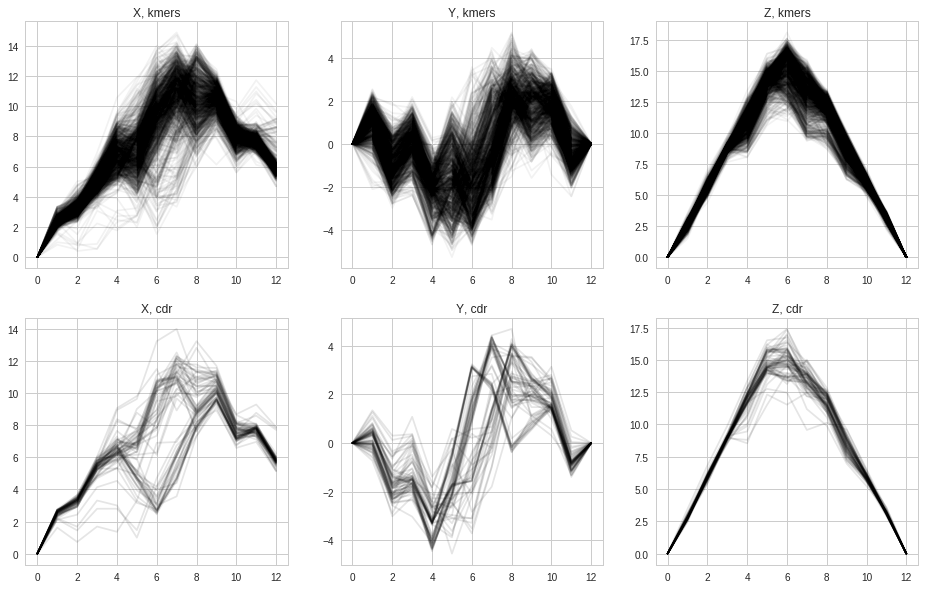

In [11]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
ax[0,0].set_title("X, kmers")
ax[0,1].set_title("Y, kmers")
ax[0,2].set_title("Z, kmers")
ax[1,0].set_title("X, cdr")
ax[1,1].set_title("Y, cdr")
ax[1,2].set_title("Z, cdr")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)

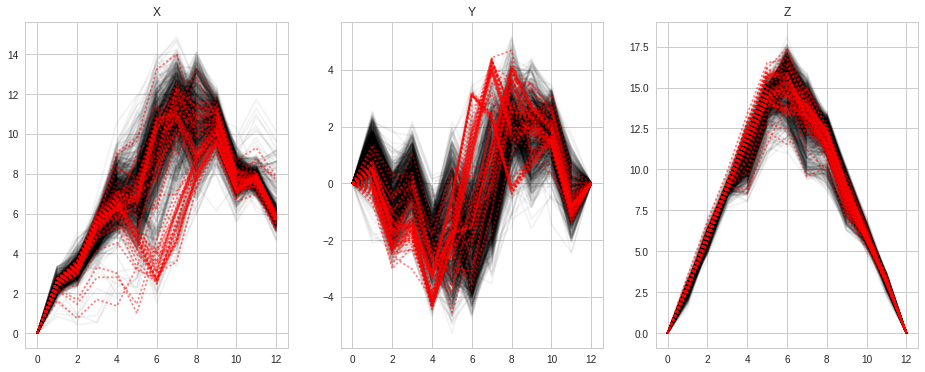

In [12]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)

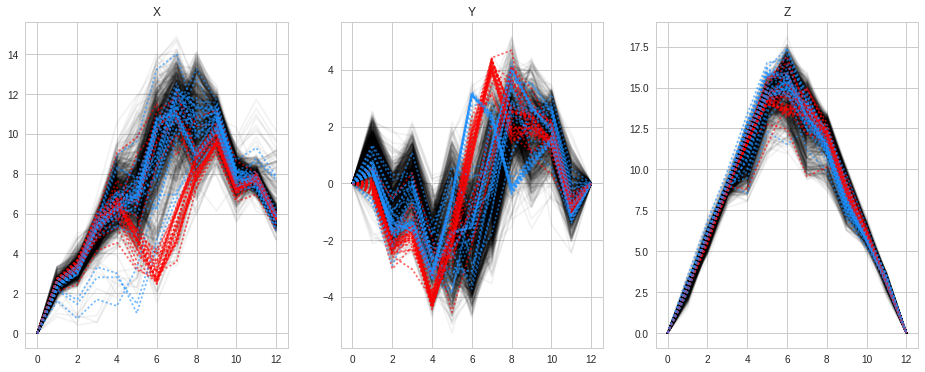

In [13]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)

## Summary
There is a clear distinction between TRA and TRB groups by the X-coordinate, with some anomalous CDRs.

TRB lines by the X-coordinate have very little neighbouring peptides in contrast to the TRA CDR chain sequences.

Real CDRs tend to have less deviation from the starting point and at the final point by the Y-coordinate.

Shape of lines for the Y-coordinate are pretty close for TRA and TRB.

# Distribution of coordinates per position

## X coordinate

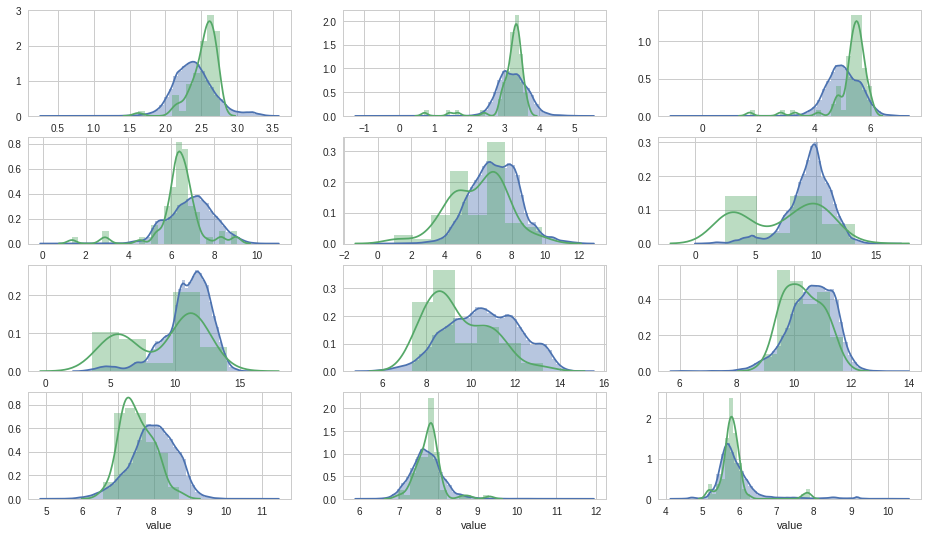

In [41]:
fig, ax = plt.subplots(4,3,figsize=(16,9))

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_x.loc[df_put_x["pos_tcr"] == j, "value"], ax=ax[r,c])
    sns.distplot(df_cdr_x.loc[df_cdr_x["pos_tcr"] == j, "value"], ax=ax[r,c])

## Y coordinate

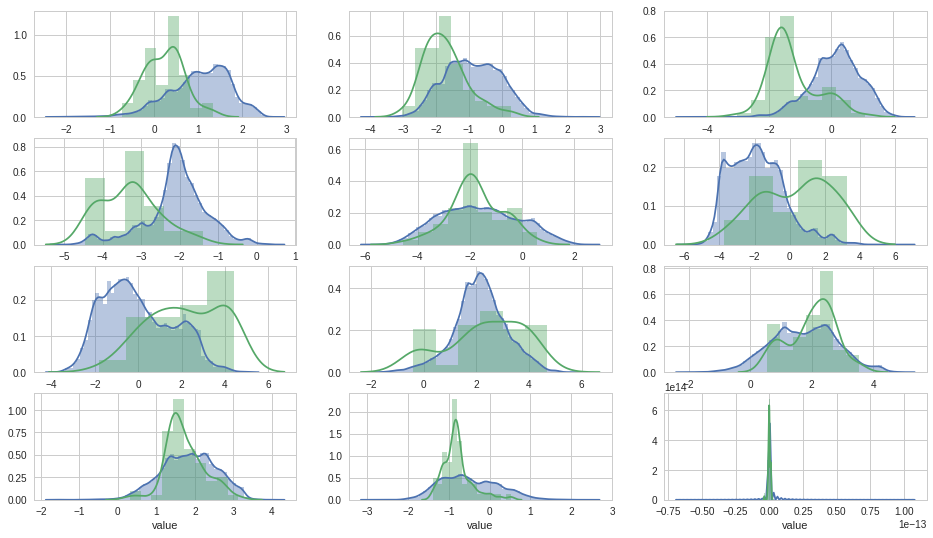

In [43]:
fig, ax = plt.subplots(4,3,figsize=(16,9))

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_y.loc[df_put_y["pos_tcr"] == j, "value"], ax=ax[r,c])
    sns.distplot(df_cdr_y.loc[df_cdr_y["pos_tcr"] == j, "value"], ax=ax[r,c])

## Z coordinate

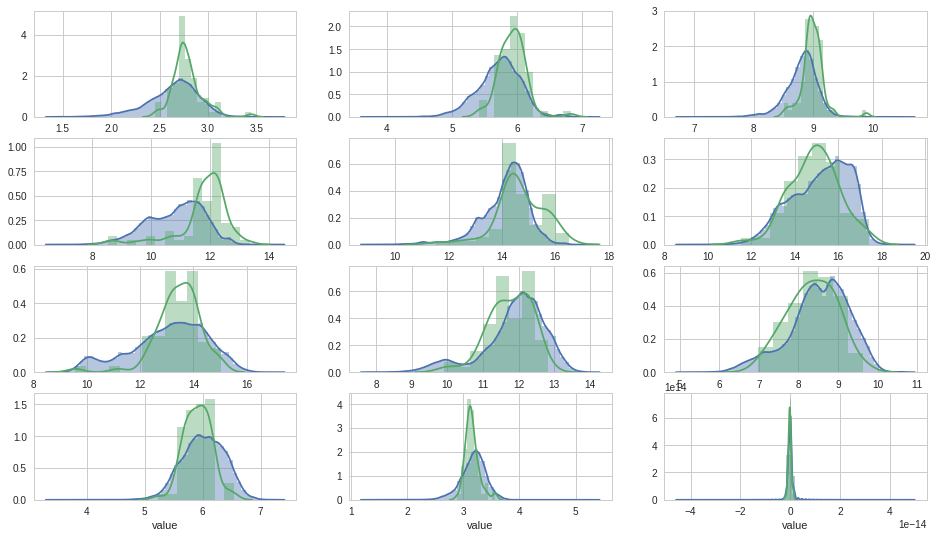

In [44]:
fig, ax = plt.subplots(4,3,figsize=(16,9))

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_z.loc[df_put_z["pos_tcr"] == j, "value"], ax=ax[r,c])
    sns.distplot(df_cdr_z.loc[df_cdr_z["pos_tcr"] == j, "value"], ax=ax[r,c])

# Anomaly analysis

In [14]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] < 6) & (df_cdr_x["tcr_chain"] == "TRA"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
864,3pqy,TRA,6,x,4.706501
890,4z7v,TRA,6,x,4.205619


In [15]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 4) & (df_cdr_x["value"] < 4) & (df_cdr_x["tcr_chain"] == "TRA"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
524,4ozh,TRA,4,x,1.357835
862,3pqy,TRA,4,x,2.798550
888,4z7v,TRA,4,x,3.000207


In [16]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] > 6) & (df_cdr_x["tcr_chain"] == "TRB"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
32,2xn9,TRB,6,x,11.144908
71,3vxr,TRB,6,x,9.548838
97,3vxs,TRB,6,x,9.711765
136,4y1a,TRB,6,x,10.337111
279,4y19,TRB,6,x,8.448482
331,3o4l,TRB,6,x,11.509035
877,1d9k,TRB,6,x,10.139364


# Correlations among coordinates

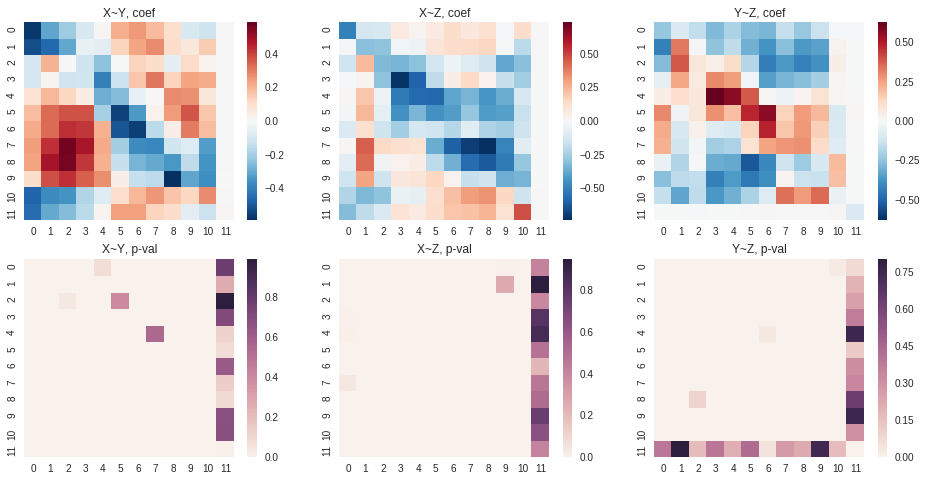

In [17]:
def plot_heatmap(df_x, df_y, df_z, fun):
    def compute(df1, df2):
        cors = np.zeros((12,12))
        pvals = np.zeros((12,12))
        for i in range(1,13):
            for j in range(1,13):
                val = stats.pearsonr(df1.loc[df1.pos_tcr == i, "value"], df2.loc[df2.pos_tcr == j, "value"])
                cors[i-1,j-1] = val[0]
                pvals[i-1,j-1] = val[1]
        return cors, pvals
    
    fig, ax = plt.subplots(2,3, figsize=(16,8))
    
    cors1, pvals1 = compute(df_x, df_y)
    ax[0,0].set_title("X~Y, coef")
    sns.heatmap(cors1, ax=ax[0,0])
    ax[1,0].set_title("X~Y, p-val")
    sns.heatmap(pvals1, ax=ax[1,0])
    
    cors2, pvals2 = compute(df_x, df_z)
    ax[0,1].set_title("X~Z, coef")
    sns.heatmap(cors2, ax=ax[0,1])
    ax[1,1].set_title("X~Z, p-val")
    sns.heatmap(pvals2, ax=ax[1,1])
    
    cors3, pvals3 = compute(df_y, df_z)
    ax[0,2].set_title("Y~Z, coef")
    sns.heatmap(cors3, ax=ax[0,2])
    ax[1,2].set_title("Y~Z, p-val")
    sns.heatmap(pvals3, ax=ax[1,2])
    
    return ((cors1, pvals1), (cors2, pvals2), (cors3, pvals3))

    
(p_c1, p_p1), (p_c2, p_p2), (p_c3, p_p3) = plot_heatmap(df_put_x, df_put_y, df_put_z, stats.pearsonr)

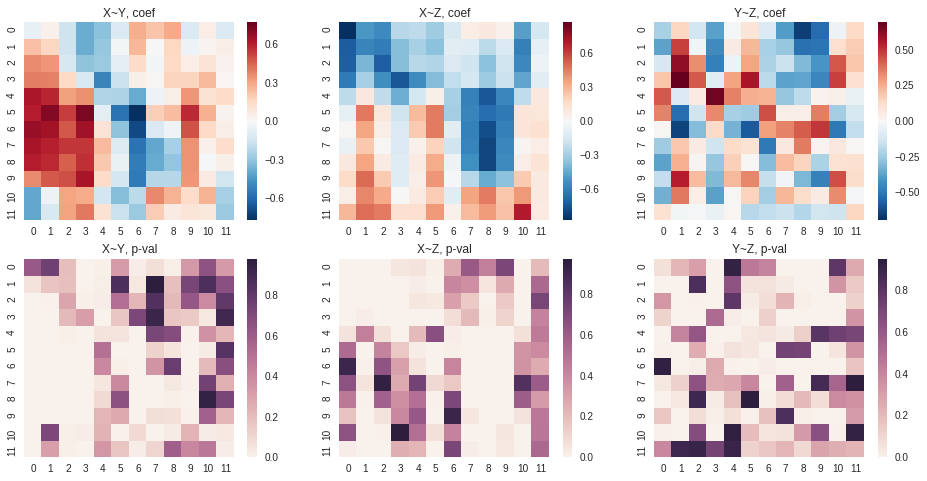

In [18]:
(c_c1, c_p1), (c_c2, c_p2), (c_c3, c_p3) = plot_heatmap(df_cdr_x, df_cdr_y, df_cdr_z, stats.pearsonr)

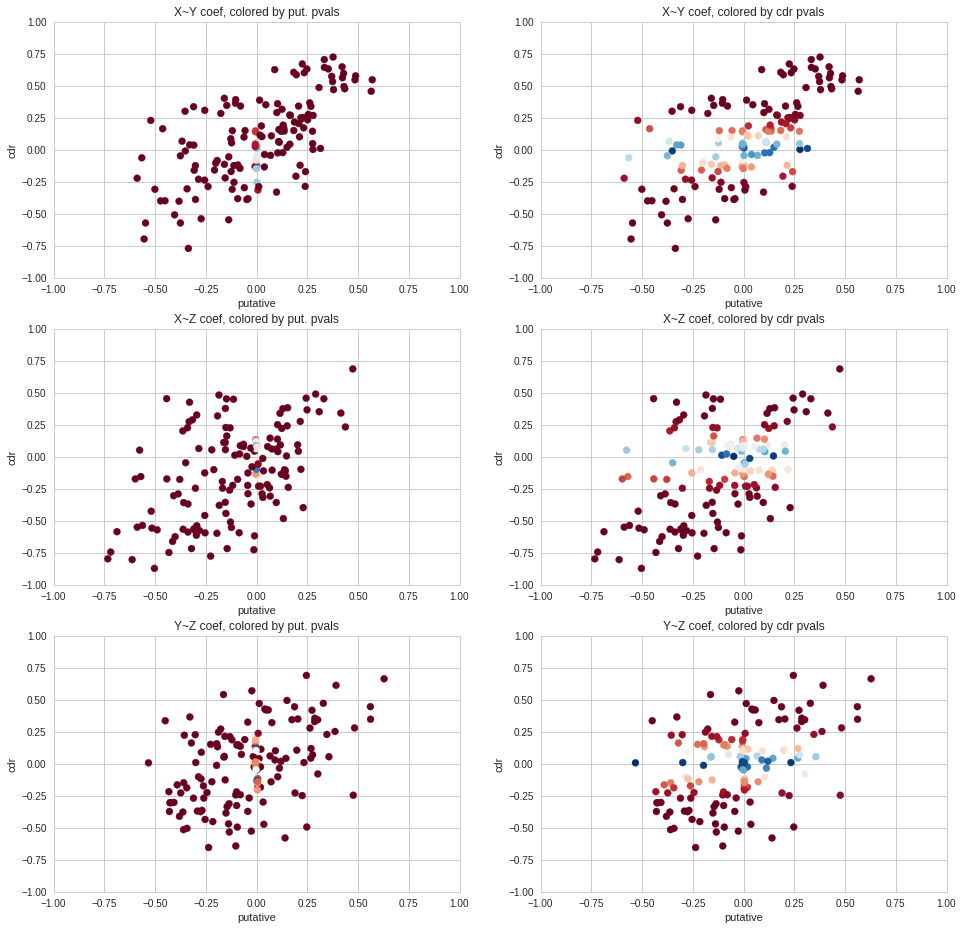

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(16,16))


ax[0,0].set_xlabel('putative')
ax[0,0].set_ylabel('cdr')
ax[0,0].set_xlim([-1,1])
ax[0,0].set_ylim([-1,1])
ax[0,0].scatter(p_c1, c_c1, c = p_p1, cmap="RdBu")
ax[0,0].set_title("X~Y coef, colored by put. pvals")

ax[0,1].set_xlabel('putative')
ax[0,1].set_ylabel('cdr')
ax[0,1].set_xlim([-1,1])
ax[0,1].set_ylim([-1,1])
ax[0,1].scatter(p_c1, c_c1, c = c_p1, cmap="RdBu")
ax[0,1].set_title("X~Y coef, colored by cdr pvals")

ax[1,0].set_xlabel('putative')
ax[1,0].set_ylabel('cdr')
ax[1,0].set_xlim([-1,1])
ax[1,0].set_ylim([-1,1])
ax[1,0].scatter(p_c2, c_c2, c = p_p2, cmap="RdBu")
ax[1,0].set_title("X~Z coef, colored by put. pvals")

ax[1,1].set_xlabel('putative')
ax[1,1].set_ylabel('cdr')
ax[1,1].set_xlim([-1,1])
ax[1,1].set_ylim([-1,1])
ax[1,1].scatter(p_c2, c_c2, c = c_p2, cmap="RdBu")
ax[1,1].set_title("X~Z coef, colored by cdr pvals")

ax[2,0].set_xlabel('putative')
ax[2,0].set_ylabel('cdr')
ax[2,0].set_xlim([-1,1])
ax[2,0].set_ylim([-1,1])
ax[2,0].scatter(p_c3, c_c3, c = p_p3, cmap="RdBu")
ax[2,0].set_title("Y~Z coef, colored by put. pvals")

ax[2,1].set_xlabel('putative')
ax[2,1].set_ylabel('cdr')
ax[2,1].set_xlim([-1,1])
ax[2,1].set_ylim([-1,1])
ax[2,1].scatter(p_c3, c_c3, c = c_p3, cmap="RdBu")
ax[2,1].set_title("Y~Z coef, colored by cdr pvals")

# Distribution of distances to the nearest putative CDR from real CDRs (by MSE)

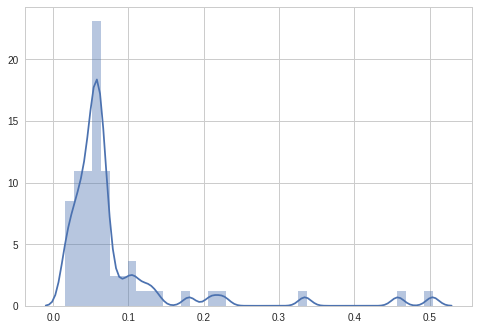

In [20]:
arr_put_coord = np.array(df_put_coord[range(1,13)])
arr_cdr_coord = np.array(df_cdr_coord[range(1,13)])

dist = []
for arr in arr_cdr_coord:
    dist.append(((arr_put_coord - arr) ** 2).mean(1).min())
    
sns.distplot(dist)